# T2K Triples

In [81]:
import os
rdirs = [rdir for rdir in os.listdir('results') if 'triples' in os.listdir(os.path.join('results', rdir))]
sorted(rdirs)

['16oct-f1-bp1',
 '19oct-v2-f1-bp1',
 '1nov-v1-check',
 '23oct-v1-goldcandidates-f1-bp1',
 '29oct-v1-goldcandidatesfixed-f1-bp1',
 '30oct-v1-goldcandidatesadded-f1-bp1',
 '31oct-v1-goldcandidatesadded-dbpediapart-f1-bp1',
 '31oct-v1-goldcandidatesadded-wikidata-labels',
 '31oct-v2-goldcandidatesadded-dbpediapart-labels',
 '31oct-v2-goldcandidatesadded-labels',
 '31oct-v2-goldcandidatesadded-wikidata-labels']

In [84]:
import os
from functools import reduce
import pandas as pd

# results_dir = 'results/16oct-f1-bp1/'
# results_dir = 'results/23oct-v1-goldcandidates-f1-bp1/'
# results_dir = 'results/29oct-v1-goldcandidatesfixed-f1-bp1/'
# results_dir = 'results/30oct-v1-goldcandidatesadded-f1-bp1/'
# results_dir = 'results/31oct-v1-goldcandidatesadded-dbpediapart-f1-bp1/'
# results_dir = 'results/31oct-v1-goldcandidatesadded-wikidata-labels/'
results_dir = 'results/1nov-v1-check/'

# !ls $results_dir

triple_dir = os.path.join(results_dir, 'triples')
triple_tables = []
methods = [m for m in os.listdir(triple_dir) if not m.endswith('.csv')]
for method in methods:
    t = pd.read_csv(os.path.join(results_dir, 'triples', method, 'extracted_triples-GOLD.csv'))
    t.rename(columns={'Subject Confidence':method}, inplace=True)
    triple_tables.append(t)
join_triples = reduce(lambda left, right: left.merge(right, how='outer'), triple_tables)
join_triples.fillna(0, inplace=True)
join_triples.to_csv(os.path.join(triple_dir, 'extracted_triples.csv'))

In [93]:
m = 't2k-final'

P = (join_triples[m]>0)
G = (join_triples['gold']>0)
K = (join_triples['Object Value matches KB'] == True)

Rpos = sum(P & G & K) / sum(P & G)
Rneg = sum((~P) & G & K) / sum(G & (~P))
print('P %.2f > %.2f' % (Rpos, Rneg))

Qnov = sum(P & G & (~K)) / sum(G & (~K))
Qred = sum(P & G & K) / sum(G & K)

print('Q %.2f < %.2f' % (Qnov, Qred))

P 0.40 > 0.24
Q 0.70 < 0.84


/export/scratch1/home/kruit/venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


redundant              False                                   True   \
                   precision    recall        f1        ap precision   
method                                                                 
t2k-final           0.671656  0.654315  0.662872  0.597860  0.881153   
sti                 0.656946  0.514968  0.577357  0.544386  0.892552   
labelscore_ft0_bp0  0.454186  0.772560  0.572059  0.447516  0.836124   
combined_ft0_bp0    0.728889  0.789629  0.758044  0.801749  0.919502   
coherence_ft0_bp0   0.717461  0.779465  0.747179  0.794662  0.914323   

redundant                                         
                      recall        f1        ap  
method                                            
t2k-final           0.819604  0.849265  0.898826  
sti                 0.701345  0.785479  0.856844  
labelscore_ft0_bp0  0.844586  0.840334  0.846354  
combined_ft0_bp0    0.856900  0.887098  0.930757  
coherence_ft0_bp0   0.848903  0.880399  0.920958

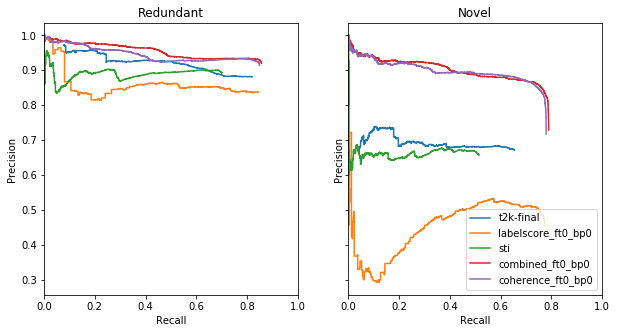

In [86]:
%matplotlib inline
import collections
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

jt = join_triples.copy()
jt = jt.drop(columns=['URL', 'Table', 'Column Index']).drop_duplicates()

scores = []
for redundant, ax in [(True, ax1), (False, ax2)]:
    for method in methods:
        if method != 'gold':
            j = jt[(jt['Object Value matches KB'] == redundant)]
            y_test = j['gold']
            y_score = j[method]
            p_curve, r_curve, _ = precision_recall_curve(list(y_test), list(y_score))
            ax.step(r_curve[1:-1], p_curve[1:-1], where='post', label='%s' % method)
            
#             f_curve = 2 / ((1/p_curve) + (1/r_curve))
#             t = f_curve[1:-1].argmax()+1
#             ax.plot([r_curve[t]], [p_curve[t]], marker='x', color="black")
#             ax.text(r_curve[t], p_curve[t], '$f_1$:%.2f' % f_curve[t])
            
            n_correct = sum((y_score > 0) & (y_test > 0))
            p = n_correct / sum(y_score > 0) if sum(y_score > 0) else 0
            r = n_correct / sum(y_test > 0) if sum(y_test > 0) else 0
            f = 2 / ((1/p) + (1/r)) if p and r else 0
            ap = average_precision_score(list(y_test), list(y_score))

            scores.append(collections.OrderedDict(
                redundant=redundant, method=method,
                precision=p,recall=r,f1=f,ap=ap,
                p_curve=p_curve, r_curve=r_curve,
            ))
            
    ax.set_title(['Novel', 'Redundant'][int(redundant)])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim([0,1])
ax.legend()

import json
json.dump(scores, os.path.join(results_dir,'triple_scores.json'))

df = pd.DataFrame(scores)
df = df[['redundant','method','precision','recall','f1','ap']]
df.columns = ['Redundant', 'System', 'Precision','Recall','$F_1$','AP']
df = df.pivot(index='System', columns='Redundant')
df.columns = df.columns.swaplevel(0, 1)
df.sortlevel(0, axis=1, inplace=True, sort_remaining=False)
df = df.reindex(index=df.index[::-1])
df

In [31]:
jt = join_triples.copy()
jt['gold and t2k'] = (jt['t2k-final'] > 0) & (join_triples['gold']>0)

print('%20s: %d triples' % ('total', len(join_triples)))

for redundant,r in [(True, 'redundant'), (False, 'novel')]:
    for m in ['gold', 't2k-final', 'gold and t2k']:
        novel_triples = jt[(jt['Object Value matches KB'] == redundant)]
        recall = (novel_triples[m]>0).sum() / (novel_triples['gold']>0).sum()
        print('%20s: %d triples, %d %s' % (r, len(novel_triples), (novel_triples[m]>0).sum(), m))

               total: 61039 triples
           redundant: 17413 triples, 15751 gold
           redundant: 17413 triples, 13740 t2k-final
           redundant: 17413 triples, 13294 gold and t2k
               novel: 43626 triples, 31199 gold
               novel: 43626 triples, 26705 t2k-final
               novel: 43626 triples, 25395 gold and t2k


In [32]:
join_triples[(join_triples['labelscore_ft0_bp0'] == 0) & (join_triples['gold'] == 1)]

,URL,Table,Column Index,Subject URI,Subject Value,t2k-final,Predicate URI,Predicate Value,Predicate Confidence,Data Type,Object Value,Object Value in KB,Object Value matches KB,Object Value Similarity,labelscore_ft0_bp0,gold,sti,combined_ft0_bp0,coherence_ft0_bp0
25,0.0,61121469_0_6337620713408906340.csv,1,http://dbpedia.org/resource/Madagascar,madagascar,0.91458,http://dbpedia.org/ontology/capital,capital city,1.0,string,antananarivo,Antananarivo,True,1.000000,0.0,1.0,2.390152,0.453828,0.215694
37,0.0,29414811_2_4773219892816395776.csv,2,http://dbpedia.org/resource/Metroid_Prime,metroid prime,0.86409,http://dbpedia.org/ontology/genre,genre,1.0,string,action-adventure,First-person (video games),False,0.000000,0.0,1.0,2.010153,0.000000,0.115581
58,0.0,29414811_2_4773219892816395776.csv,4,http://dbpedia.org/resource/Metroid_Prime,metroid prime,0.86409,http://dbpedia.org/ontology/developer,developer(s),1.0,string,nintendo,{Nintendo|Retro Studios},False,0.000000,0.0,1.0,2.010153,0.000000,0.115581
79,0.0,29414811_2_4773219892816395776.csv,0,http://dbpedia.org/resource/Metroid_Prime,metroid prime,0.86409,http://dbpedia.org/ontology/year,year,1.0,date,2002-01-01T00:00,0,False,0.000000,0.0,1.0,2.010153,0.000000,0.115581
100,0.0,29414811_2_4773219892816395776.csv,3,http://dbpedia.org/resource/Metroid_Prime,metroid prime,0.86409,http://dbpedia.org/ontology/computingPlatform,platform(s),1.0,string,nintendo gamecube,{Wii|GameCube},False,0.000000,0.0,1.0,2.010153,0.000000,0.115581
142,0.0,38428277_0_1311643810102462607.csv,3,http://dbpedia.org/resource/The_Matrix,the matrix,0.94778,http://dbpedia.org/ontology/director,director(s),1.0,string,andy and larry wachowski,0,False,0.000000,0.0,1.0,1.808122,1.175978,0.494569
156,0.0,38428277_0_1311643810102462607.csv,3,http://dbpedia.org/resource/Nosferatu,nosferatu,0.95268,http://dbpedia.org/ontology/director,director(s),1.0,string,f.w. murnau,F. W. Murnau,True,1.000000,0.0,1.0,2.200000,0.928786,0.247377
176,0.0,38428277_0_1311643810102462607.csv,3,http://dbpedia.org/resource/Philadelphia_(film),philadelphia,0.67564,http://dbpedia.org/ontology/director,director(s),1.0,string,jonathan demme,Jonathan Demme,True,1.000000,0.0,1.0,1.976326,1.206883,0.525473
183,0.0,38428277_0_1311643810102462607.csv,3,http://dbpedia.org/resource/Manhattan_(film),manhattan,0.68078,http://dbpedia.org/ontology/director,director(s),1.0,string,woody allen,Woody Allen,True,1.000000,0.0,1.0,1.966326,1.200140,0.518730
196,0.0,38428277_0_1311643810102462607.csv,3,http://dbpedia.org/resource/Moulin_Rouge!,moulin rouge!,0.96707,http://dbpedia.org/ontology/director,director(s),1.0,string,baz luhrmann,Baz Luhrmann,True,1.000000,0.0,1.0,0.000000,0.000000,0.000000


# Properties
not used now

In [8]:
import os, glob
import pandas as pd

In [28]:
gold_path = './data_t2k/v1/'
gold_prop_fname = os.path.join(gold_path,'gs_property.csv') # needed for gold subject column
gs_property = pd.read_csv(gold_prop_fname, header=None, names=['col', 'uri', 'gold'])
gs_property['table'], gs_property['columnIndex'] = zip(*(s.split('~Col') for s in gs_property['col']))
gs_property['columnIndex'] = gs_property['columnIndex'].map(int)

In [29]:
our_path = './results/16oct-f1-bp1/'
our_property = pd.concat([
    pd.read_csv(fname).append(pd.DataFrame({'table':[]}), sort=False).fillna(os.path.basename(fname))
    for fname in glob.glob(os.path.join(our_path, 'property', '*'))
])